# Spike shape predicts sparse cell misses

author: steeve.laquitaine@epfl.ch

Test Hyp: Missed sparse cell spike shapes are distinct from the detected cells' ones, which fit one of KS3's six universal templates.

Approach: compare their distance (proxy for shape similarity) to the universal templates in a projection space.


1. We want the spike and universal template projection coordinates to only depend on their shapes, which we define as their voltage dynamic. A template and a spike with identical voltage dynamic have identical shapes, irrespective of the magnitude or timing of their peak, as one can align and scale the template to perfectly fit the spike. Pachitariu 2023 actually do something similar during template matching. That means that each spike will be associated with a best fit template.

2. Because W has the unit norm (norm=1), W^T.D, the projection of vector D on vector W (the best fit of W to D) has norm x, which is also the best matching amplitude that the template needs to be multiplied by to match the data.

3. The spikes D should be unit-normed if we instead want to fix a universal template and fit all spikes to that template (a form of spike normalization).

4. We might be able to decompose Pachitariu 2023's template deconvolution (template fitting) into a sequence of spike alignment with a fixed template by maximizing their cross-correlation, then a projection (best-fit scaling) of the template-aligned spikes onto the template. Spike alignment with template remains the same after re-scaling templates or spikes. (note: the mathematical calculation of Correlation is same as convolution in time domain, except that the signal is not reversed, before the multiplication process). Temporal convolution consists in sliding the kernel (our template) on the recording and performing the dot product. We could directly apply temporal convolution between template and spikes and use the max energy signal lag to align spikes with the template, the dot product also yields the best fit rescaled template for each spike or vvs.


## Setup

Virtual env is `env_kilosort_silico`

You should have extracted the templates from a KS3 run by running `python3.9 -m src.pipes.postpro.univ_temp` in the terminal before. See usage in `univ_temp` module.


In [4]:
# SETUP PACKAGES 
%load_ext autoreload
%autoreload 2
import os 
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from spikeinterface.comparison import GroundTruthStudy
from IPython.display import Image
from scipy.signal import correlate
from scipy.signal import correlation_lags

# SET DIMENSIONALITY REDUCTION tools
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# SET PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting"
os.chdir(PROJ_PATH)

from src.nodes.utils import get_config
from src.nodes.dataeng.deepnet.dataeng import get_instances
from src.nodes.dataeng.silico import probe_wiring
from src.nodes.dataeng.silico.filtering import filter_microcircuit_cells
from src.nodes.prepro import preprocess
from src.nodes.truth.silico import ground_truth
from src.nodes.io.silico.loading import load_campaign_params
from src.pipes.postpro import waveform, univ_temp
from src.nodes import viz

# SET DATA PATH 
# whole campaign files
SPIKE_FILE_PATH = '/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/dataeng/0_silico/neuropixels_lfp_10m_2023_02_19/f3c730ef-8dd9-4d6d-8c18-3ddb7d3eeee7/campaign/raw/spiketrains.pkl'
RAW_LFP_TRACE_FILE_PATH = '/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/dataeng/0_silico/neuropixels_lfp_10m_2023_02_19/f3c730ef-8dd9-4d6d-8c18-3ddb7d3eeee7/campaign/raw/traces.pkl'
CELL_TRACE_FILE_PATH = '/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/dataeng/0_silico/neuropixels_lfp_10m_2023_02_19/f3c730ef-8dd9-4d6d-8c18-3ddb7d3eeee7/campaign/raw/cells/cell_3754013_trace.pkl'


# SET PARAMETERS
EXPERIMENT = "silico_neuropixels"
SIMULATION_DATE = "2023_02_19"
STUDY_FOLDER = '/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/sorting/0_silico/neuropixels_lfp_10m_2023_02_19/f3c730ef-8dd9-4d6d-8c18-3ddb7d3eeee7/campaign/study'
EXAMPLE_CELL_ID = 4209594
EXAMPLE_CHANNEL_ID = 20
MS_BEFORE = 3           # ms
MS_AFTER = 3            # ms
CELL_TYPE = "PYR"
LOAD_WAVEFORM_EXTRACTOR = False
LOAD_GROUND_TRUTH = True
LOAD_PREP_TRACE = True


# SET CONFIG
data_conf, param_conf = get_config(EXPERIMENT, SIMULATION_DATE).values()


# SET MODEL INPUT DATA PATHS
INSTANCE_FILE_PATH = data_conf["sorting"]["deepnet"]["input"]["instances"]
CHANNEL_IDS_FILE_PATH = data_conf["sorting"]["deepnet"]["input"]["channel_ids"]
CELL_LABELS_FILE_PATH = data_conf["sorting"]["deepnet"]["input"]["cell_labels"]
SPIKE_STATUS_FILE_PATH = data_conf["sorting"]["deepnet"]["input"]["spike_status"]
NEAREST_CHANNEL_FILE_PATH  = data_conf["sorting"]["deepnet"]["input"]["nearest_channel"]

# SET PLOT PARAMETERS
cmap = plt.get_cmap("tab20")
colors = cmap(np.linspace(0,1,24))[:,:3]

# set colors for detected 
detected_colors = colors[:12,]
missed_colors = colors[12:,]

2023-05-04 15:24:30,650 - root - utils.py - get_config - INFO - Reading experiment config.
2023-05-04 15:24:30,766 - root - utils.py - get_config - INFO - Reading experiment config. - done
2023-05-04 15:24:30,784 - root - utils.py - get_config - INFO - Reading experiment config.
2023-05-04 15:24:30,824 - root - utils.py - get_config - INFO - Reading experiment config. - done
2023-05-04 15:24:30,843 - root - utils.py - get_config - INFO - Reading experiment config.
2023-05-04 15:24:30,882 - root - utils.py - get_config - INFO - Reading experiment config. - done


In [5]:
# custom functions
def pca_spikes(axis, spike_instances, labels, detection_status):

    # Instantiate PCA
    pca_model = PCA(n_components=2)

    # Performs PCA
    pca_model.fit(spike_instances)

    # take first two principal components
    PCA(n_components=2)

    # Perform PCA
    embedding = pca_model.transform(spike_instances);

    # separate detected and missed data
    scores_for_detected = embedding[detection_status==1,:]
    scores_for_missed = embedding[detection_status==0,:]
    cell_labels_for_detected = labels[detection_status==1]
    cell_labels_for_missed = labels[detection_status==0]

    # plot reduced detected spikes
    edgecolor = np.tile(np.array([[1],[1],[1]]), len(missed_colors)).T
    visualize_components(
        axis, component1=scores_for_detected[:,0], component2=scores_for_detected[:,1], labels=cell_labels_for_detected, colors=detected_colors, markerfacecolor=detected_colors,
        edgecolor=edgecolor
        );

    # plot reduced missed spikes
    markerfacecolor = np.tile(np.array([[1],[1],[1]]), len(missed_colors)).T
    visualize_components(
        axis, component1=scores_for_missed[:,0], component2=scores_for_missed[:,1], labels=cell_labels_for_missed,  colors=missed_colors, markerfacecolor=markerfacecolor, 
        edgecolor=missed_colors
        );
    plt.legend();
    return embedding

def tsne_spikes(axis, spike_instances, labels, detection_status):

    # instantiate tsne
    tsne_model = TSNE(n_components=2, perplexity=70, random_state=2020)

    # perform t-SNE
    embedding = tsne_model.fit_transform(spike_instances)

    # separate detected and missed data
    embedding_for_detected = embedding[detection_status==1,:]
    embedding_for_missed = embedding[detection_status==0,:]
    cell_labels_for_detected = labels[detection_status==1]
    cell_labels_for_missed = labels[detection_status==0]
    
    # plot reduced detected spikes
    edgecolor = np.tile(np.array([[1],[1],[1]]), len(missed_colors)).T
    visualize_components(
        axis, component1=embedding_for_detected[:,0], component2=embedding_for_detected[:,1], labels=cell_labels_for_detected, colors=detected_colors, markerfacecolor=detected_colors,
        edgecolor=edgecolor
        );

    # plot reduced missed spikes
    markerfacecolor = np.tile(np.array([[1],[1],[1]]), len(missed_colors)).T
    visualize_components(
        axis, component1=embedding_for_missed[:,0], component2=embedding_for_missed[:,1], labels=cell_labels_for_missed,  colors=missed_colors, markerfacecolor=markerfacecolor,
        edgecolor=missed_colors
        );
    plt.legend();
    return embedding

def visualize_components(ax, component1, component2, labels, colors, markerfacecolor, edgecolor):
  """
  Plots a 2D representation of the data for visualization with categories
  labelled as different colors.

  Args:
    component1 (numpy array of floats) : Vector of component 1 scores
    component2 (numpy array of floats) : Vector of component 2 scores
    labels (numpy array of floats)     : Vector corresponding to categories of
                                         samples

  Returns:
    Nothing.

  """
  for label in np.unique(labels):
      label_loc = labels==label
      x = component1[label_loc]
      y = component2[label_loc]
      ax.plot(x, y, marker="o", color=colors[label,:], markerfacecolor=markerfacecolor[label,:], linestyle="none", label=label, markeredgecolor=edgecolor[label,:])
  
  # legend
  ax.set_xlabel("component1", fontsize=9)
  ax.set_ylabel("component2", fontsize=9)
  ax.axis('equal')

1. fix a channel
2. find nearby ground truth cells (within 40 microns of the channel)
3. fit the cell spikes and universal templates with tsne and project on a 2D space
4. get seed templates, missed sparse cells , detected sparse cells  


spike dataset engineering was done with '/gpfs/bbp.cscs.ch/data/project/proj68/home/laquitai/spike-sorting/notebooks/2_deepnet/0b_dataeng_neuropix_32.ipynb'

## Check templates, missed, detected cell spikes

In [6]:
# load spike data
all_instances = pd.read_pickle(INSTANCE_FILE_PATH)
channel_ids = pd.read_pickle(CHANNEL_IDS_FILE_PATH)
cells = pd.read_pickle(CELL_LABELS_FILE_PATH)
spike_status = pd.read_pickle(SPIKE_STATUS_FILE_PATH)
nearest_channel = pd.read_pickle(NEAREST_CHANNEL_FILE_PATH)

spike count: 66
2023-05-04 15:24:44,800 - root - ground_truth.py - load - INFO - loading already processed ground truth SortingExtractor ...
2023-05-04 15:24:44,868 - root - ground_truth.py - load - INFO - loading already processed true sorting - done in 0.1
spike count: 5
2023-05-04 15:24:44,968 - root - ground_truth.py - load - INFO - loading already processed ground truth SortingExtractor ...
2023-05-04 15:24:44,984 - root - ground_truth.py - load - INFO - loading already processed true sorting - done in 0.0


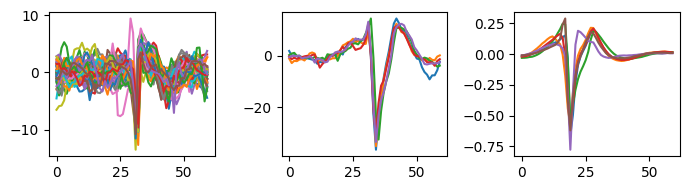

In [7]:
# plot a missed sparse cell
NEAREST_CHANNEL = 30
MISSED_CELL = 165135
DETECTED_CELL = 19690

# setup plots
fig, axes = plt.subplots(1,3, figsize=(7,2))

# plot a missed sparse cell
missed_cell_instances = all_instances.iloc[np.where((cells.values==MISSED_CELL) & (channel_ids.values==NEAREST_CHANNEL) & (spike_status.values==True))[0].tolist()]
axes[0].plot(missed_cell_instances.T);
print("spike count:", missed_cell_instances.shape[0])
Truth = ground_truth.load(data_conf)
assert Truth.get_total_num_spikes()[MISSED_CELL] == missed_cell_instances.shape[0], "spike count does not make sense"

# plot a detected sparse cell
detected_cell_instances = all_instances.iloc[np.where((cells.values==DETECTED_CELL) & (channel_ids.values==NEAREST_CHANNEL) & (spike_status.values==True))[0].tolist()]
axes[1].plot(detected_cell_instances.T);
print("spike count:", detected_cell_instances.shape[0])
Truth = ground_truth.load(data_conf)
assert Truth.get_total_num_spikes()[DETECTED_CELL] == detected_cell_instances.shape[0], "spike count does not make sense"

# plot Kilosort3's six universal templates
univ_templates = univ_temp.load(data_conf)
univ_templates = univ_templates.T[:,:-1]
univ_templates = univ_templates
axes[2].plot(univ_templates.T);
plt.tight_layout()

The dot product `W^T.D` provides the scaling amplitude of the best fitted template.

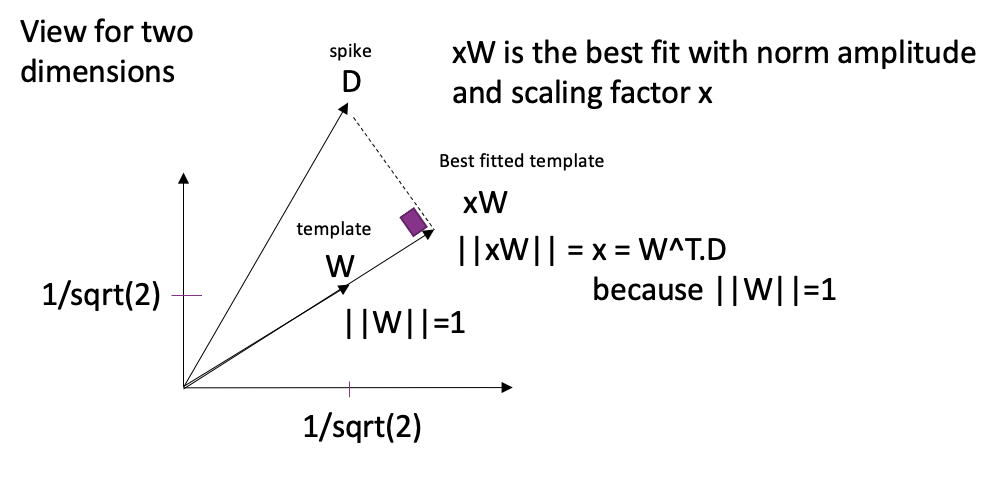

euclidean norm amplitude of D projection on W: 1.5909902576697321
dot product: 1.590990257669732


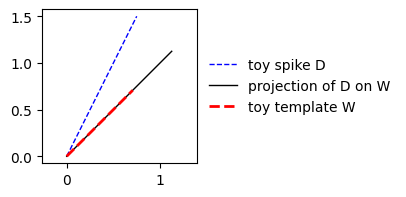

In [136]:
# show how the dot product provide the scaling amplitude of the best fitted template
display(Image(filename="notebooks/1_results/assets/template_fitting.png", width=800))

def show_that_dot_product_is_amplitude_x():

    # create unit norm vector W (toy template)
    W = np.array([1/np.sqrt(2), 1/np.sqrt(2)])

    # create vector D (toy spike)
    D = np.array([0.75, 1.5])

    # finding norm of the vector W
    W_norm = np.sqrt(sum(W**2))	

    # project v on u 
    proj_of_D_on_W = (np.dot(D, W)/W_norm**2)*W

    # plot
    _, axis = plt.subplots(1,1, figsize=(2,2))
    axis.plot([0, D[0]],[0, D[1]], "b--", linewidth=1, label="toy spike D");
    axis.plot([0, proj_of_D_on_W[0]],[0, proj_of_D_on_W[1]], "k", linewidth=1, label="projection of D on W");
    axis.plot([0, W[0]],[0, W[1]], "r--", linewidth=2, label="toy template W");

    # report
    print("euclidean norm amplitude of D projection on W:", np.sqrt(sum(proj_of_D_on_W**2)))
    print("dot product:", np.dot(D,W))
    axis.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False);
    axis.axis("equal")

show_that_dot_product_is_amplitude_x()

euclidean norm amplitude of W projection on D: 0.9486832980505137
dot product: 1.590990257669732


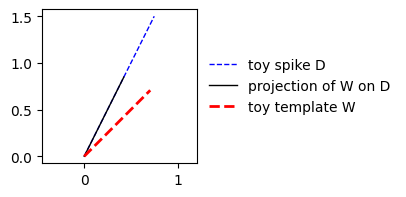

In [139]:
# show how the dot product of W onto D does not provide the scaling amplitude of the best fitted spike to the template
def show_that_dot_product_is_amplitude_x():

    # create unit norm vector W (toy template)
    W = np.array([1/np.sqrt(2), 1/np.sqrt(2)])

    # create vector D (toy spike)
    D = np.array([0.75, 1.5])

    # finding norm of the vector u
    D_norm = np.sqrt(sum(D**2))	

    # project v on u 
    proj_of_W_on_D = (np.dot(W, D)/D_norm**2)*D

    # plot
    _, axis = plt.subplots(1,1, figsize=(2,2))
    axis.plot([0, D[0]],[0, D[1]], "b--", linewidth=1, label="toy spike D");
    axis.plot([0, proj_of_W_on_D[0]],[0, proj_of_W_on_D[1]], "k", linewidth=1, label="projection of W on D");
    axis.plot([0, W[0]],[0, W[1]], "r--", linewidth=2, label="toy template W");
    axis.axis("equal")

    # report
    print("euclidean norm amplitude of W projection on D:", np.sqrt(sum(proj_of_W_on_D**2)))
    print("dot product:", np.dot(W,D))
    axis.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False);

show_that_dot_product_is_amplitude_x()

euclidean norm amplitude of W projection on D: 0.8944271909999161
dot product: 0.8944271909999157


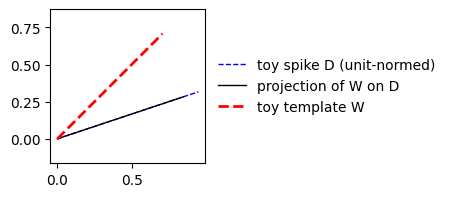

In [138]:
# show how the dot product of W onto D provides the scaling amplitude of the best fitted spike to the template
def show_that_dot_product_is_amplitude_x():

    # create unit norm vector W (toy template)
    W = np.array([1/np.sqrt(2), 1/np.sqrt(2)])

    # create vector D (toy spike)
    D = np.array([0.75, 0.25])

    # unit-normalize D
    D_norm = np.sqrt(sum(D**2))	
    D_unit_normed = D / D_norm
    D_norm = np.sqrt(sum(D_unit_normed**2))

    # project v on u 
    proj_of_W_on_D = (np.dot(W, D_unit_normed)/D_norm**2)*D_unit_normed

    # plot
    _, axis = plt.subplots(1,1, figsize=(2,2))
    axis.plot([0, D_unit_normed[0]],[0, D_unit_normed[1]], "b--", linewidth=1, label="toy spike D (unit-normed)");    
    axis.plot([0, proj_of_W_on_D[0]],[0, proj_of_W_on_D[1]], "k", linewidth=1, label="projection of W on D");
    axis.plot([0, W[0]],[0, W[1]], "r--", linewidth=2, label="toy template W");
    

    # report
    print("euclidean norm amplitude of W projection on D:", np.sqrt(sum(proj_of_W_on_D**2)))
    print("dot product:", np.dot(W,D_unit_normed))
    axis.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False);
    axis.axis("equal")
    
show_that_dot_product_is_amplitude_x()

## Fit (align and scale) templates

Cons:
- padding spikes and templates with zeros during alignment does not change the alignment but will change the best fit (projection) of the templates onto the spikes. 
Pachitariu 2023 do not pad with zeros nor modify the spikes or templates. They convolve the templates onto the entire recording to find the best fit.

We could solve this by extracting spike waveforms over longer periods (- and + 6 ms instead of 3 ms), aligning (without padding) then cropping at - and + 3ms from the negative peak.

For now we solve it by fixing a universal template, and aligning and scaling all spikes to best fit that template (i.e., all spikes are normalized to that template). The more distant cell dots to that template dot in the reduced space have the most shapes and we predict that they should be the ones missed.

1. align all spikes to template 1.
2. crop spike and template boundaries to all have a common period. 
3. scale all spikes to best fit template 1.
4. reduce

- convolve takes the argmax

In [198]:
def align_with_crosscorr(template, spike):

    # calculate lag
    corr = correlate(spike, template, mode="full")
    lags = correlation_lags(spike.size, template.size, mode="full")
    lag = lags[np.argmax(corr)]        
    
    # shift spike indices by lag
    spike.index = spike.index - lag
    print(lag)
    return spike

def align_with_conv(template, spike):

    # calculate lag
    corr = np.convolve(template, spike, mode="same")
    lag = np.argmax(corr)
    
    # shift spike indices by lag
    spike.index = spike.index - lag
    print(lag)
    return spike

def plot_aligned_spike_and_template(template, spike):
    plt.subplots(figsize=(3, 3))
    spike.plot(label="spike");
    template.plot(label="template", color="r", linestyle="--");
    plt.legend(loc="best");

15
25


-15     1.855799
-14    -0.025347
-13     0.197422
-12    -0.066493
-11    -0.822020
-10    -0.857515
-9     -1.334317
-8     -1.011816
-7     -1.253537
-6     -1.528949
-5     -1.727691
-4     -3.154902
-3     -2.452965
-2     -2.618815
-1     -1.870249
0      -0.441255
1       0.245240
2       0.433991
3       0.094031
4       0.528619
5       1.349815
6       0.449583
7       3.284452
8       4.360368
9       4.841100
10      5.569482
11      5.672550
12      6.570124
13      5.652832
14      6.350343
15      6.462132
16     11.355050
17     -0.324774
18    -22.794098
19    -36.753574
20    -23.878675
21    -16.626652
22     -8.765048
23     -3.124564
24      1.529958
25      7.167973
26     12.553663
27     14.542155
28     12.719846
29     10.223115
30      9.593291
31      8.085055
32      5.624666
33      3.148577
34      0.725689
35     -1.120054
36     -1.425381
37     -4.473763
38     -6.384546
39     -7.409226
40     -9.247767
41     -7.706358
42     -7.654270
43     -5.6948

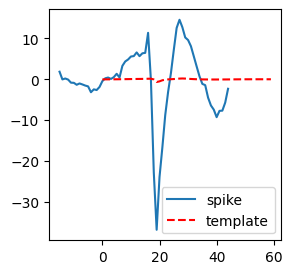

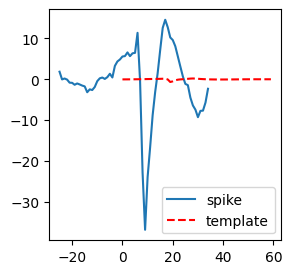

In [199]:
spike_cc = align_with_crosscorr(template, detected_cell_instances.iloc[0])
plot_aligned_spike_and_template(template, spike_cc)

spike_conv = align_with_conv(template, detected_cell_instances.iloc[0])
plot_aligned_spike_and_template(template, spike_conv)

# plt.plot(np.convolve(template, detected_cell_instances.iloc[0], "same"))
# plt.plot(correlate(template, detected_cell_instances.iloc[0], mode="same"))
spike_cc

In [107]:
# all_instances = pd.Series(np.vstack([missed_cell_instances, detected_cell_instances]))
pd.DataFrame(data=all_instances)

(71, 60)

10
22
6
23
26
11
22
12
12
11
11
11
12
12
12
12
11
-3
-19
22
12
12
12
25


/tmp/ipykernel_177937/1708666100.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.subplots(figsize=(3, 3))


11
23
3
21
25
11
24
12
6
11
9
22
1
11
11
12
12
12
23
22
22
12
6
11
12
11
24
12
-5
23
11
22
22
22
11
11
12
26
10
23
26
11
15
15
15
14
15


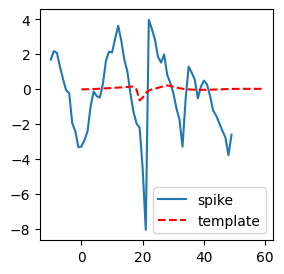

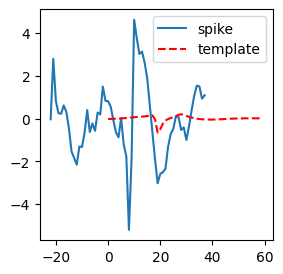

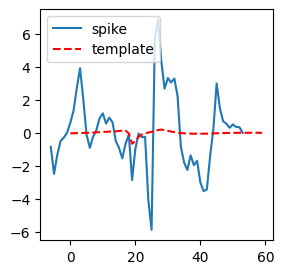

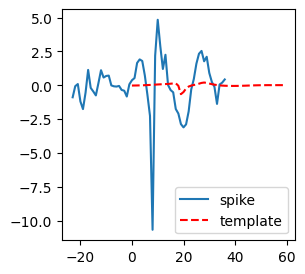

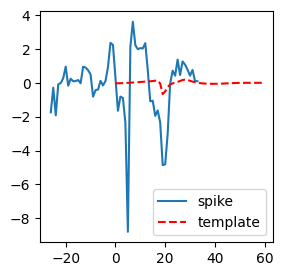

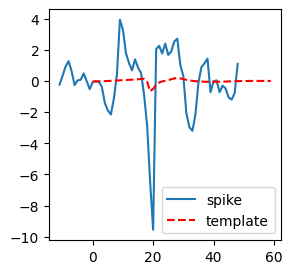

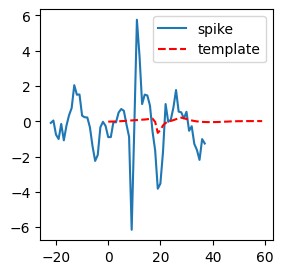

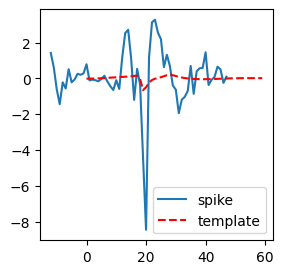

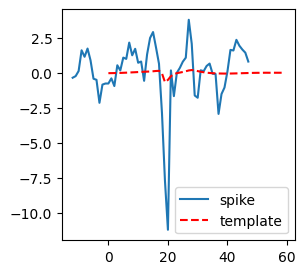

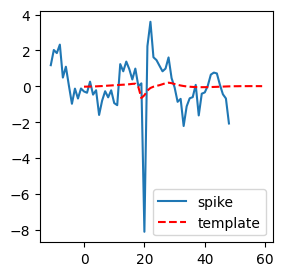

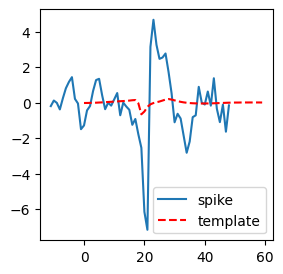

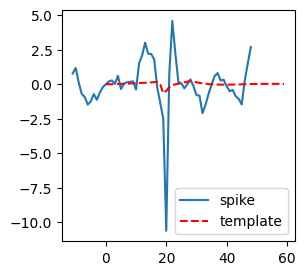

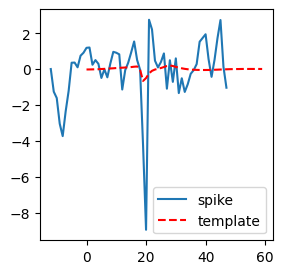

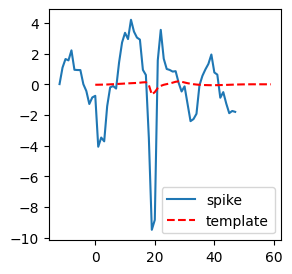

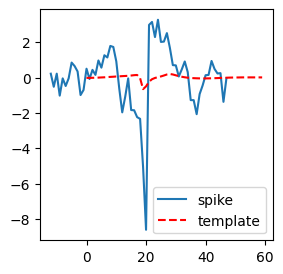

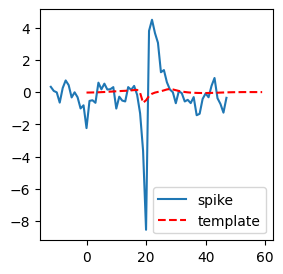

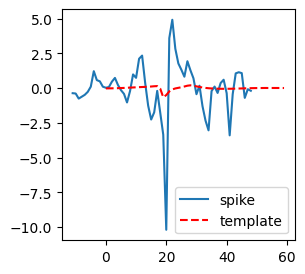

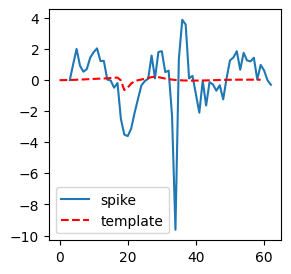

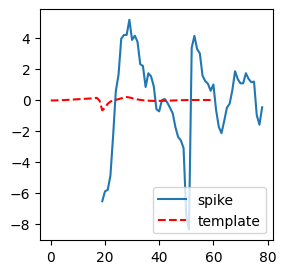

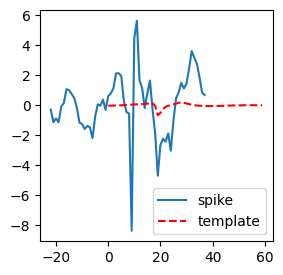

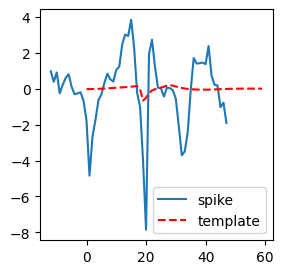

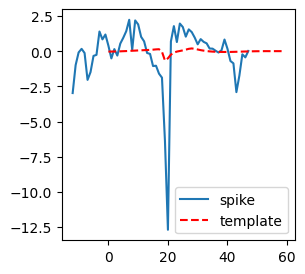

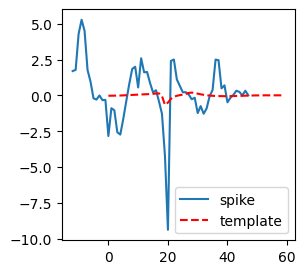

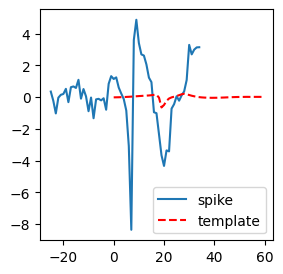

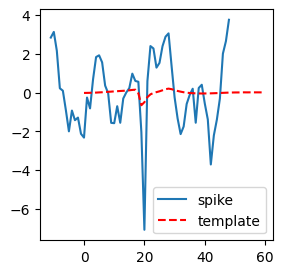

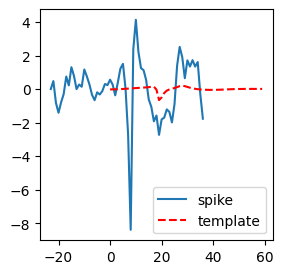

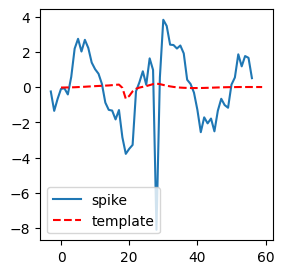

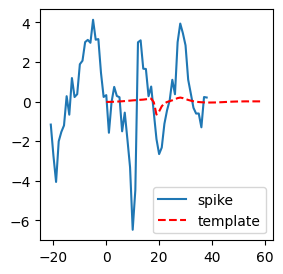

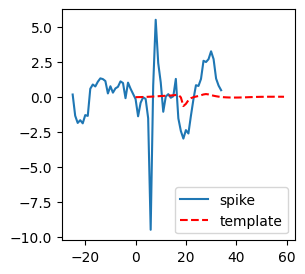

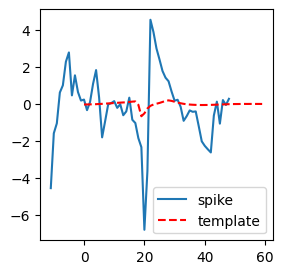

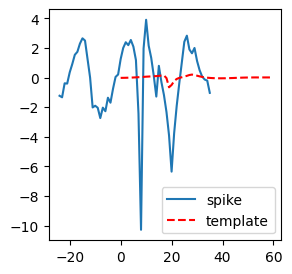

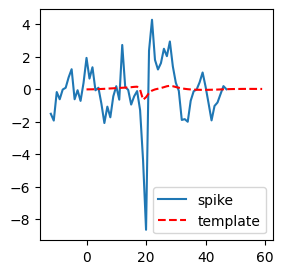

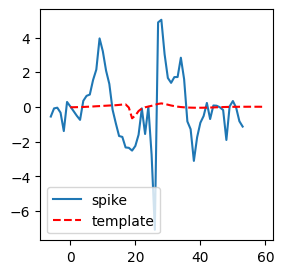

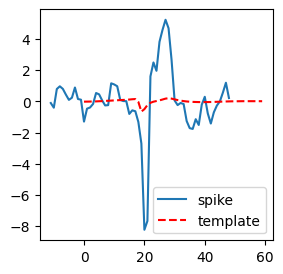

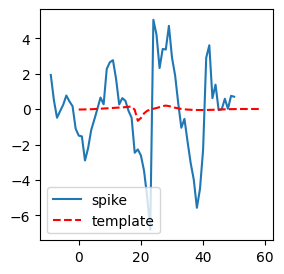

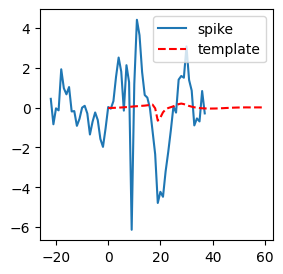

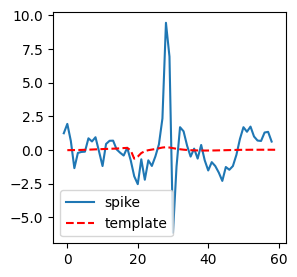

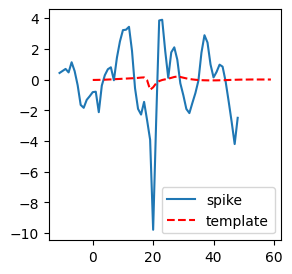

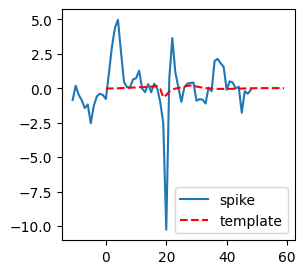

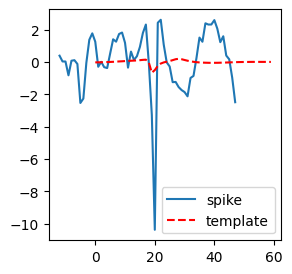

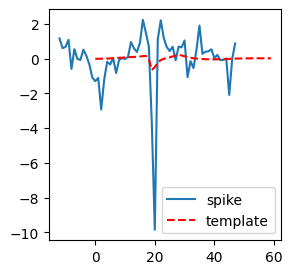

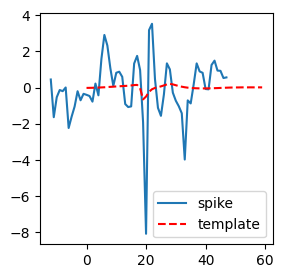

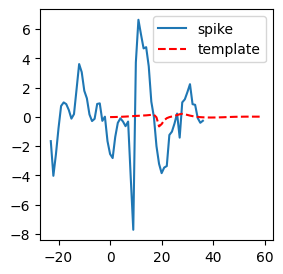

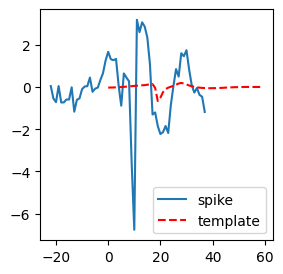

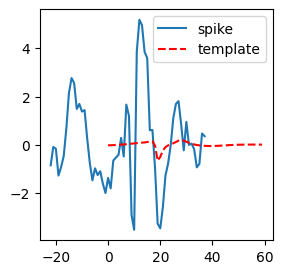

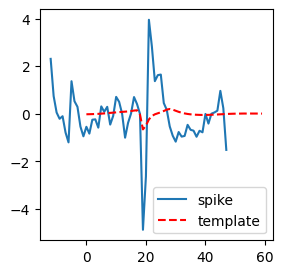

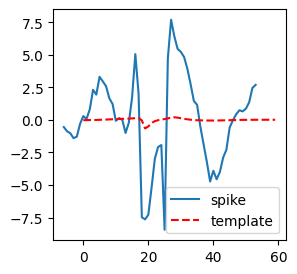

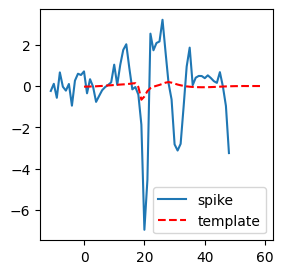

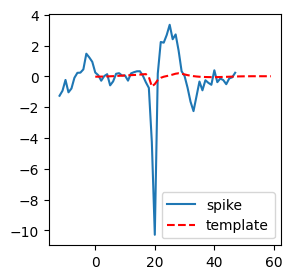

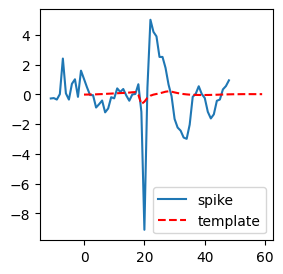

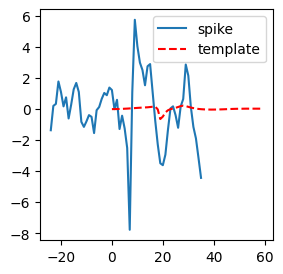

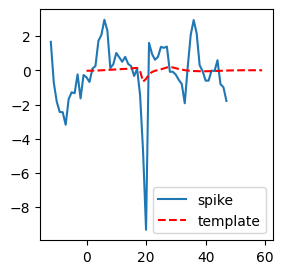

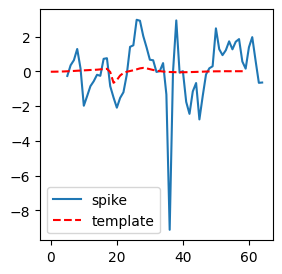

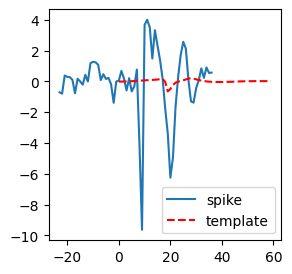

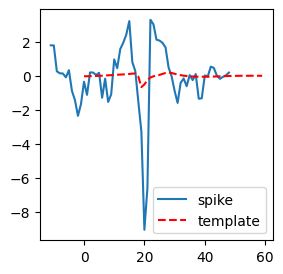

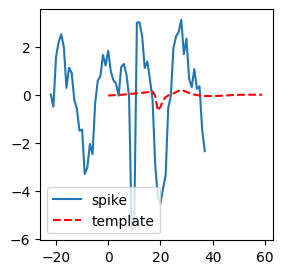

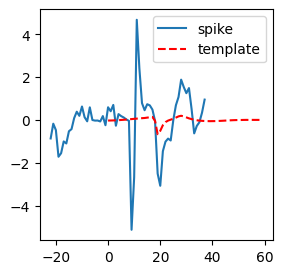

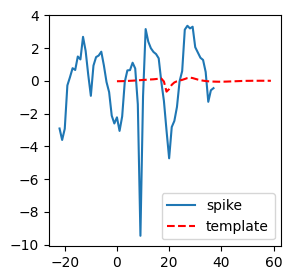

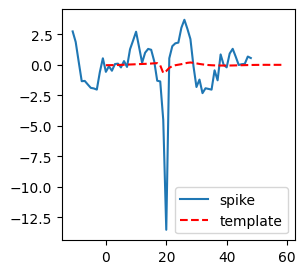

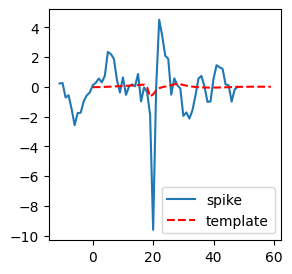

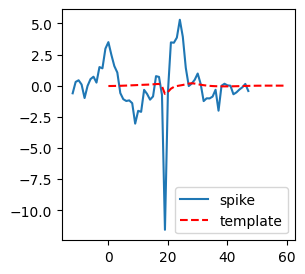

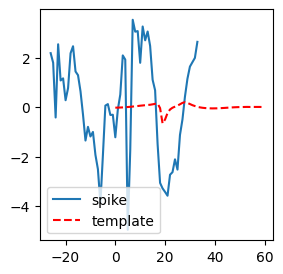

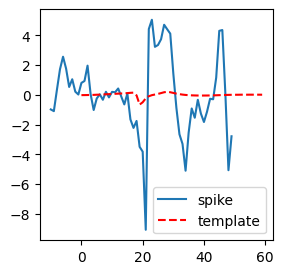

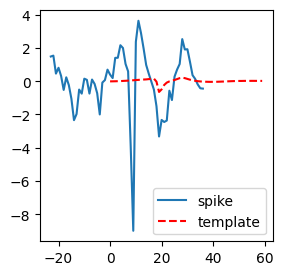

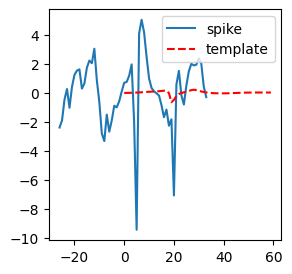

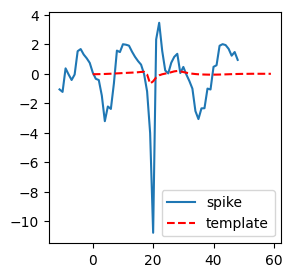

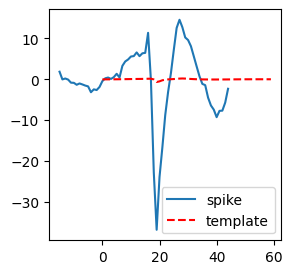

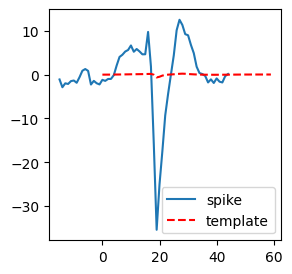

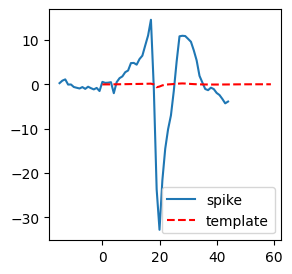

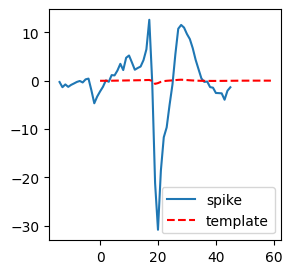

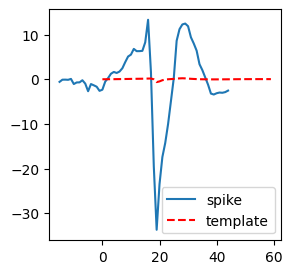

In [108]:
# fix a template
template = pd.Series(univ_templates[0,:])

# get spikes
all_instances = pd.DataFrame(np.vstack([missed_cell_instances, detected_cell_instances]))

aligned_spikes = []
for ix in range(all_instances.shape[0]): 
    spike = all_instances.iloc[ix]
    aligned_spike = align_with_crosscorr(template, spike)
    aligned_spikes.append(aligned_spike)
    plot_aligned_spike_and_template(template, spike)

22


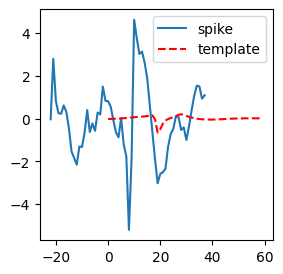

In [152]:
# fix a template
template = pd.Series(univ_templates[0,:])

# get spikes
all_instances = pd.DataFrame(np.vstack([missed_cell_instances, detected_cell_instances]))

spike = all_instances.iloc[1]
aligned_spike = align(template, spike)
plot_aligned_spike_and_template(template, spike)

22


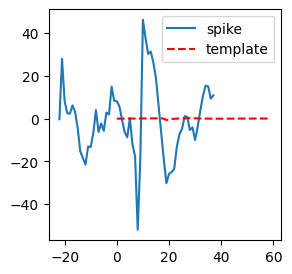

In [154]:
SCALE = 10

# fix a template
template = pd.Series(univ_templates[0,:])

# get spikes
all_instances = pd.DataFrame(np.vstack([missed_cell_instances, detected_cell_instances]))

spike = all_instances.iloc[1] * SCALE
aligned_spike = align(template, spike)
plot_aligned_spike_and_template(template, spike)

Best lag: 15
Best lag: 10


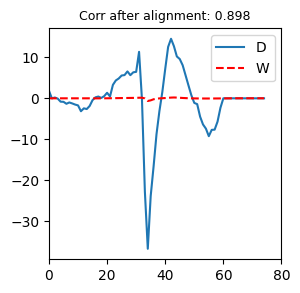

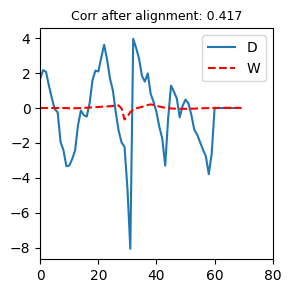

In [172]:
def shift_to_max_corr(D, W):
    correlation = correlate(D, W, mode="full")
    lags = correlation_lags(D.size, W.size, mode="full")
    lag = lags[np.argmax(correlation)]
    print(f"Best lag: {lag}")
    pad = pd.Series([0]*(abs(lag)))

    if lag < 0:
        # add zero 
        # ding before D
        D = pd.concat([pad, D]).reset_index(drop=True)
        
        # add zero padding before W
        W = pd.concat([W, pad]).reset_index(drop=True)
    else:
        # add zero padding after D
        D = pd.concat([D, pad]).reset_index(drop=True)
        
        # add zero padding before W
        W = pd.concat([pad, W]).reset_index(drop=True)
    return D, W

# def corr(x, y):
#     shortest = min(x.shape[0], y.shape[0])
#     return np.corrcoef(x.iloc[:shortest].values, y.iloc[:shortest].values)[0, 1]

# get a spike and template
D_detected = detected_cell_instances.iloc[0].values
W = univ_templates[0,:]

# align
shifted_D, shifted_W = shift_to_max_corr(pd.Series(D_detected), pd.Series(W))

# plot aligned
plt.subplots(figsize=(3, 3))
shifted_D.plot(label="D");
shifted_W.plot(label="W", color="r", linestyle="--");
plt.xlim([0,80]);
# plt.title(f"Corr after alignment: {round(corr(shifted_D, shifted_W),3)}", fontsize=9);
plt.legend(loc="best");

# case missed spike
D_missed = missed_cell_instances.iloc[0].values

# align
shifted_D, shifted_W = shift_to_max_corr(pd.Series(D_missed), pd.Series(W))

# plot aligned
plt.subplots(figsize=(3, 3))
shifted_D.plot(label="D");
shifted_W.plot(label="W", color="r", linestyle="--");
plt.xlim([0,80]);
plt.title(f"Corr after alignment: {round(corr(shifted_D, shifted_W),3)}", fontsize=9);
plt.legend(loc="best");

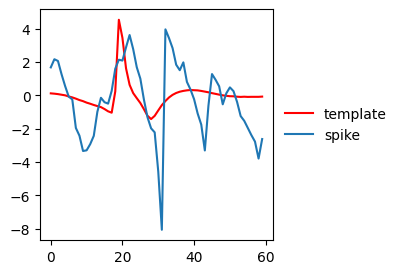

In [166]:
# show a real missed spike and its best fit (its projection on a) template
D = missed_cell_instances.iloc[0].values
W = univ_templates[0,:]
amplitude_x = np.dot(D, W)

plt.subplots(figsize=(3, 3))
plt.plot(amplitude_x * W, "r", label="template");
plt.plot(D, label="spike");
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False);

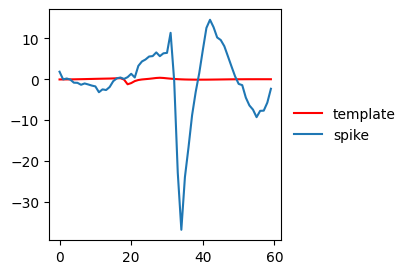

In [168]:
# show a real detected spike and its best fit (its projection on a) template
D = detected_cell_instances.iloc[0].values
amplitude_x = np.dot(D, W)

plt.subplots(figsize=(3, 3))
plt.plot(amplitude_x * W, "r", label="template");
plt.plot(D, label="spike");
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False);

### Engineer missed spike data

In [20]:
# set missed sparse firing cell ids near the same contact
NEAREST_CHANNEL = 30
MISSED_CELL_IDS = [165135, 273515, 288502, 342702]

# get their spikes (samples x timepoint features)
missed_sparse_loc = np.where((cells.values==MISSED_CELL_IDS) & (channel_ids.values==NEAREST_CHANNEL) & (spike_status.values==True))[0].tolist()
missed_sparse_instances = all_instances.iloc[missed_sparse_loc,:]

# create associated cell labels
missed_sparse_cell_labels = cells.values[missed_sparse_loc]
missed_sparse_instances

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
6270,1.684903,2.175474,2.072452,1.276201,0.563353,-0.066877,-0.239182,-1.954975,-2.418681,-3.338788,...,0.484793,0.257643,-0.391453,-1.239462,-1.526665,-1.956234,-2.388787,-2.774238,-3.793741,-2.620123
6302,-0.032775,2.794358,0.816915,0.251501,0.225295,0.616050,0.316962,-0.450223,-1.536359,-1.846021,...,-0.533130,-0.413546,-1.002446,-0.376406,0.375169,1.064075,1.539470,1.506827,0.931708,1.089978
6334,-0.841169,-2.480600,-1.327081,-0.494029,-0.281319,0.012176,0.611190,1.364112,2.716395,3.928662,...,0.229933,3.007326,1.507290,0.711943,0.558773,0.315905,0.519014,0.364521,0.352777,0.014600
6366,-0.884621,-0.064664,0.093386,-1.189407,-1.755603,-0.543964,1.135347,-0.190149,-0.455310,-0.745802,...,2.536827,1.771548,2.105812,0.912035,0.247716,-0.109475,-1.372017,0.057579,0.195668,0.430882
6398,-1.731552,-0.273901,-1.911146,-0.074722,-0.000478,0.281099,0.969969,-0.159929,0.255279,0.107241,...,0.432565,1.385690,0.470758,1.277080,1.085446,0.786312,0.434861,0.772529,0.115026,0.106477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15518,-0.020087,0.389070,-0.056558,-1.284781,-2.267252,-2.346345,-1.552391,-0.714128,0.372042,0.347865,...,-0.492557,-1.538212,-0.623913,-2.244401,-1.694306,-2.265906,-1.476180,-0.810699,-0.069911,-2.907492
15550,0.256426,-0.731933,-1.054649,-0.883698,-0.566242,-0.108410,-0.724213,-0.752015,-0.101782,0.526800,...,3.329808,0.143395,0.074879,-0.850814,-2.125506,-3.352760,-7.600870,-7.150776,-3.623568,-2.421188
15582,0.626030,1.789311,1.824467,2.727166,-0.336295,-0.700235,-1.320516,-0.907825,1.101532,1.573721,...,0.447865,-1.145236,-2.498279,-2.112000,-1.927291,-2.166399,-2.365030,-1.922926,-2.480718,-0.552703
15614,0.826226,1.997759,2.140790,2.339364,0.994669,-0.485496,-0.963626,-0.635207,-1.185573,-1.980380,...,-0.252449,-2.188362,-3.285719,-3.962533,-4.623040,-3.529523,-3.127395,-3.295677,-3.177359,-2.492269


### Engineer detected spike data

In [21]:
# set detected sparse firing cells near the same contact
DETECTED_CELL_IDS = [19690, 367098]

# get their spikes (samples x timepoint features)
detected_sparse_loc = np.where((cells.values==DETECTED_CELL_IDS) & (channel_ids.values==NEAREST_CHANNEL) & (spike_status.values==True))[0].tolist()
detected_sparse_instances = all_instances.iloc[detected_sparse_loc,:]

# create associated cell labels
detected_sparse_cell_labels = cells.values[detected_sparse_loc]

### Engineer missed sparse cells' spike data

In [22]:
# concatenate into data for dim. reduction
near_contact_instances = np.vstack([missed_sparse_instances, detected_sparse_instances])

# convert cell label to integer labels
near_contact_cell_labels = np.vstack([missed_sparse_cell_labels, detected_sparse_cell_labels])
labels_as_intg = np.unique(near_contact_cell_labels, axis=0, return_inverse=True)[1]

# add detection status label (detected are "1", missed "0")
detection_status = np.sum(near_contact_cell_labels == DETECTED_CELL_IDS, axis=1)

### Add univ templates to the instances

In [23]:
# label universal templates by incrementing the cell labels already in the instances
univ_templates_labels = np.arange(1, univ_templates.shape[0]+1,1) + max(labels_as_intg)

# add
labels = np.hstack([labels_as_intg, univ_templates_labels])
instances = np.vstack([near_contact_instances, univ_templates])
detected = np.hstack([detection_status, np.ones(univ_templates.shape[0])])

We plotted missed (empty circle) and detected (full circles) cell spikes near the same contact, on a reduced feature space.

note: the projection coordinates change when we:
- apply multiplicative scaling to the spike waveform

## Plot raw templates and spikes

2023-05-03 18:19:26,725 - matplotlib.legend - legend.py - _parse_legend_args - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting/env_silico/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting/env_silico/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


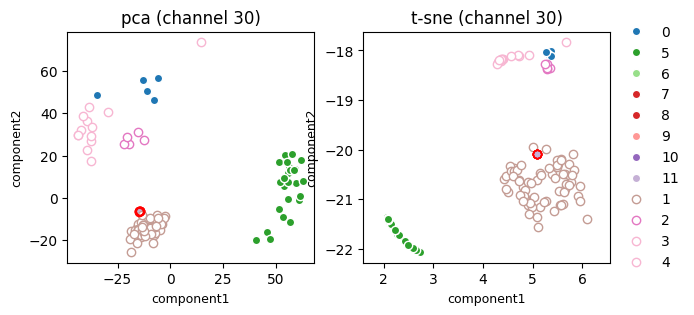

In [24]:
# Plot the data and reconstruction
fig, axes = plt.subplots(1,2, figsize=(7,3))

# apply dim. reductions
pca_embedding = pca_spikes(axis=axes[0], spike_instances=instances, labels=labels, detection_status=detected)
tsne_embedding = tsne_spikes(axis=axes[1], spike_instances=instances, labels=labels, detection_status=detected)

# legend
axes[0].set_title(f"pca (channel {NEAREST_CHANNEL})")
axes[1].set_title(f"t-sne (channel {NEAREST_CHANNEL})")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False);

# highlight univ. templates
axes[0].plot(pca_embedding[-6:,0], pca_embedding[-6:,1], marker='o', color="r", fillstyle='none', linestyle="none");
axes[1].plot(tsne_embedding[-6:,0], tsne_embedding[-6:,1], marker='o', color="r", fillstyle='none', linestyle="none");